# Numerical solution of the Poisson–Boltzmann equation in 2D
### Reshaping of the discussed equations into numerical form: Réka Somogyfoki @ ELTE

In [369]:
import sys
import numpy as np
from numba import jit
from datetime import datetime
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, clear_output

## Figure params

In [370]:
figsave_dir = '..\\out\\'

figsize_x = 15
figsize_y = 13

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Used constants

In [371]:
nx = 400
ny = 400
xmin = 0
xmax = 0.2
ymin = 0
ymax = 0.2

# Elementary charge [C]
e = 1.60217662e-19
# Boltzmann constant [J/K]
k_B = 1.38e-23
# Temperature [K]
T = 297
kT = k_B * T

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

## Laplace equation

Electric field in the classical vacuum is zero:
$$
\frac{\partial^{2} \Phi}{\partial x^{2}}
+
\frac{\partial^{2} \Phi}{\partial y^{2}}
=
0
$$

In [372]:
@jit(nopython=True)
def step_laplace2d(p, y, dx, dy):
    
    pn = p.copy()
        
    # 
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
                      dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) /
                     (2 * (dx**2 + dy**2)))

    # Set all borders to zero
    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0
    
    return p, pn

In [373]:
def laplace2d(p, y, dx, dy, l1norm_target):
    
    l1norm = 1
    while l1norm > l1norm_target:
        
        p, pn = step_laplace2d(p, y, dx, dy)

        if np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) != 0:
            continue
        elif np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) == 0:
            break
        else:
            l1norm = np.sum(np.abs(p) - np.abs(pn)) / np.sum(np.abs(pn))

    return p

In [374]:
p  = np.zeros((ny, nx))
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

p_lap = laplace2d(p, y, dx, dy, l1norm_target=1e-4)

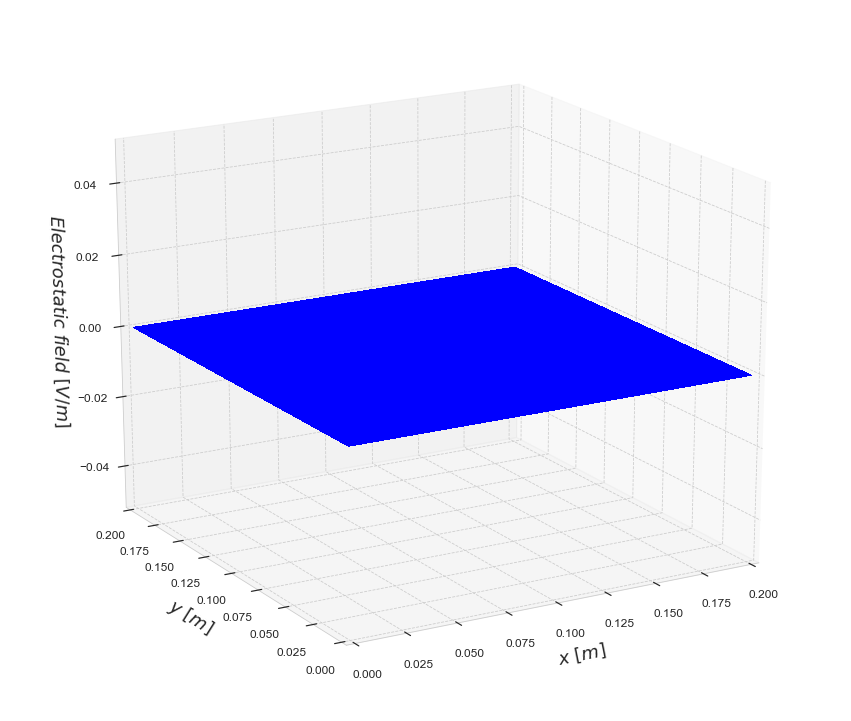

In [375]:
save = True
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsize_x,nrows*figsize_y),
                         subplot_kw={'projection': '3d'})
axes.view_init(20, 240)

axislabelsize = 18
axisticksize = 12
axislabelpad = 19
axistickpad = 12

X, Y = np.meshgrid(x, y)
axes.plot_surface(X, Y, p_lap,
                  rstride=1, cstride=1, cmap='winter', linewidth=0, antialiased=False)

axes.set_xlim(xmin, xmax)
axes.set_ylim(ymin, ymax)
axes.set_xlabel('$x\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_ylabel('$y\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_zlabel('$Electrostatic\ field\ [V/m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)

axes.tick_params(axis='both', which='major',
                 pad=axistickpad, labelsize=axisticksize)

if save:
    fig.savefig(figsave_dir +
                'lap0.png')

plt.show()

## Poisson equation

Poisson equation describes the potential of a charge distribution as follows:
$$
\frac{\partial^{2} \Phi}{\partial x^{2}}
+
\frac{\partial^{2} \Phi}{\partial y^{2}}
+
\frac{\varrho}{\varepsilon_{r}\varepsilon_{0}}
=
0
$$
If we introduce the electric field $\vec{E} = - \vec{\nabla} \Phi$, then we get the Gauss's law:

$$
\frac{\partial E_{x}}{\partial x}
+
\frac{\partial E_{y}}{\partial y}
-
\frac{\varrho}{\varepsilon_{r}\varepsilon_{0}}
=
0
$$

In [412]:
@jit(nopython=True)
def step_poisson2d(p, y, b, dx, dy):
    
    pn = p.copy()
    
    #
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, :-2]) +
                      dx**2 * (pn[2:, 1:-1] + pn[:-2, 1:-1]) -
                      b[1:-1, 1:-1] * dx**2 * dy**2) /
                     (2 * (dx**2 + dy**2)))

    # Set all borders to zero
    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0
    
    return p, pn

In [413]:
def poisson2d(p, y, b, dx, dy, l1norm_target):
    
    l1norm = 1
    while l1norm > l1norm_target:
        
        p, pn = step_poisson2d(p, y, b, dx, dy)
        
        if np.sum(np.abs(pn)) != 0 and np.sum(np.abs(p)) != 0:
            l1norm = np.sum(np.abs(p) - np.abs(pn)) / np.sum(np.abs(pn))
            sys.stdout.flush()
            sys.stdout.write('\rCurrent: {0:.6f}\tTarget: {1:.6f}'.format(l1norm, l1norm_target))
        
        elif np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) != 0:
            continue
        
        elif np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) == 0:
            break
     
    return p

In [414]:
p  = np.zeros((ny, nx))
b  = np.zeros((ny, nx))
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

b[ny // 4, nx // 4] = 200
b[ny // 2, nx // 4] = -200
b[3*ny // 4, 3 * nx // 4] = -200

start = datetime.now()
p_poi = poisson2d(p, y, b, dx, dy, l1norm_target=8e-5)
clear_output()
print('Elapsed time :', datetime.now() - start)

Elapsed time : 0:01:15.951080


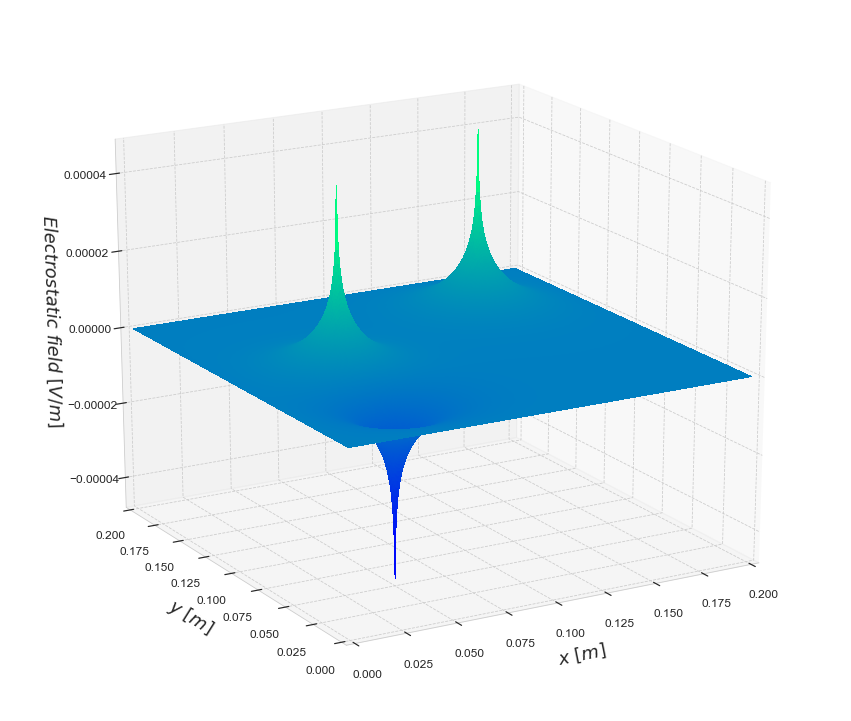

In [415]:
save = True
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsize_x,nrows*figsize_y),
                         subplot_kw={'projection': '3d'})
axes.view_init(20, 240)

axislabelsize = 18
axisticksize = 12
axislabelpad = 19
axistickpad = 12

X, Y = np.meshgrid(x, y)
axes.plot_surface(X, Y, p_poi,
                  rstride=1, cstride=1, cmap='winter', linewidth=0, antialiased=False)

axes.set_xlim(xmin, xmax)
axes.set_ylim(ymin, ymax)
axes.set_xlabel('$x\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_ylabel('$y\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_zlabel('$Electrostatic\ field\ [V/m]$',
                labelpad=axislabelpad+5, fontsize=axislabelsize)

axes.tick_params(axis='both', which='major',
                 pad=axistickpad, labelsize=axisticksize)

if save:
    fig.savefig(figsave_dir +
                'poi0.png')

plt.show()

## Poisson-Boltzmann equation

In [380]:
@jit(nopython=True)
def step_poissonboltzmann2d(p, y, b, dx, dy):
    
    pn = p.copy()

    #
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, :-2]) +
                      dx**2 * (pn[2:, 1:-1] + pn[:-2, 1:-1]) -
                      b[1:-1, 1:-1] * dx**2 * dy**2) /
                     (2 * (dx**2 + dy**2) - b[1:-1, 1:-1] * dx**2 * dy**2 * e / kT))

    # Set all borders to zero
    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0
    
    return p, pn

In [381]:
def poissonboltzmann2d(p, y, b, dx, dy, l1norm_target):
    
    l1norm = 1
    while l1norm > l1norm_target:
        
        p, pn = step_poissonboltzmann2d(p, y, b, dx, dy)
        
        if np.sum(np.abs(pn)) != 0 and np.sum(np.abs(p)) != 0:
            l1norm = np.sum(np.abs(p) - np.abs(pn)) / np.sum(np.abs(pn))
            sys.stdout.flush()
            sys.stdout.write('\rCurrent: {0:.6f}\tTarget: {1:.6f}'.format(l1norm, l1norm_target))
        
        elif np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) != 0:
            continue
        
        elif np.sum(np.abs(pn)) == 0 and np.sum(np.abs(p)) == 0:
            break
     
    return p

In [382]:
p  = np.zeros((ny, nx))
b  = np.zeros((ny, nx))
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

b[ny // 4, nx // 4] = 200
b[ny // 2, nx // 4] = -200
b[3*ny // 4, 3 * nx // 4] = -200

start = datetime.now()
p_poibol = poissonboltzmann2d(p, y, b, dx, dy, l1norm_target=8e-5)
clear_output()
print('Elapsed time :', datetime.now() - start)

Elapsed time : 0:01:37.144544


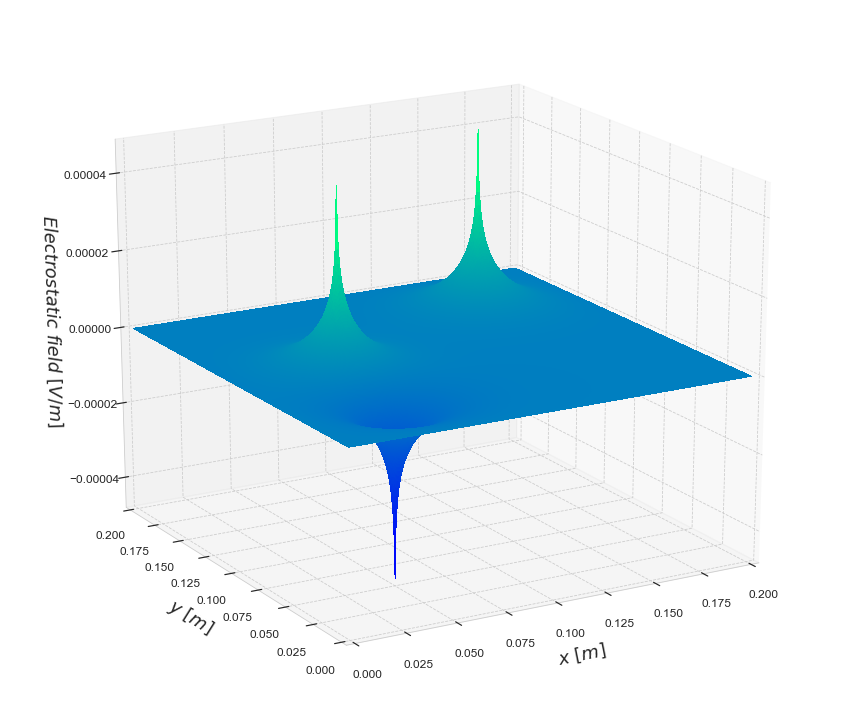

In [403]:
save = True
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsize_x,nrows*figsize_y),
                         subplot_kw={'projection': '3d'})
axes.view_init(20, 240)

axislabelsize = 18
axisticksize = 12
axislabelpad = 19
axistickpad = 12

X, Y = np.meshgrid(x, y)
axes.plot_surface(X, Y, p_poibol,
                  rstride=1, cstride=1, cmap='winter', linewidth=0, antialiased=False)

axes.set_xlim(xmin, xmax)
axes.set_ylim(ymin, ymax)
axes.set_xlabel('$x\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_ylabel('$y\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_zlabel('$Electrostatic\ field\ [V/m]$',
                labelpad=axislabelpad+5, fontsize=axislabelsize)

axes.tick_params(axis='both', which='major',
                 pad=axistickpad, labelsize=axisticksize)

if save:
    fig.savefig(figsave_dir +
                'poibol0.png')

plt.show()

## Peaks according to Boltzmann distribution

In [384]:
def sign_choose():
    return -1 if np.random.random() < 0.5 else 1

In [424]:
def boltzmann(r, r_0, C):
    return r_0 ** np.exp(-C*r) - 1

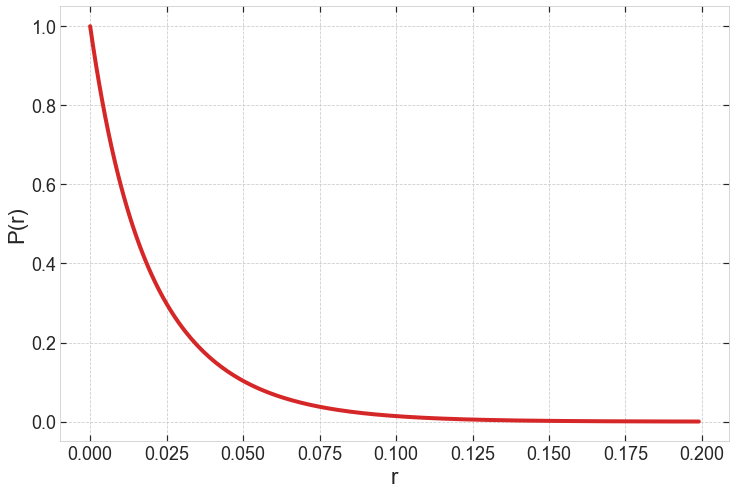

In [425]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()

axislabelsize = 22
axisticksize = 18

X = np.arange(0,0.2,0.001)
ax.plot(X, boltzmann(X, r_0=2, C=e/kT),
        color='tab:red', lw=4)

ax.set_xlabel('r', fontsize=axislabelsize)
ax.set_ylabel('P(r)', fontsize=axislabelsize)
ax.tick_params(axis='both', which='major', labelsize=axisticksize)

if save:
    fig.savefig(figsave_dir +
                'boltzmann_dist.png')

plt.show()

In [387]:
def choose_color(d, side_L):
    start = 0.25
    stop = 1.0
    if d < side_L:
        m = interp1d([0, side_L], [start, stop])
        return cm.viridis(m(d))
    else:
        return cm.viridis(stop)

In [388]:
# Number of random points
n_points = 2000

# Array to store xy coordinates of points
points = np.zeros((n_points,2))
# Color array for more SPECTACULAR view
colors = []

# Side length of plotted region
side_L = 0.2

# Points chosen so far
n = 0
while n < n_points:
    x = np.random.random() * side_L * sign_choose()
    y = np.random.random() * side_L * sign_choose()
    v = np.random.random()
    
    # Distance from center
    d = np.sqrt(x**2+y**2)
    
    if v < boltzmann(d, r_0=2, C=38):
        points[n][0] = x
        points[n][1] = y    
        colors.append(choose_color(d, side_L))#*np.sqrt(2)))
        n += 1
colors = np.array(colors)

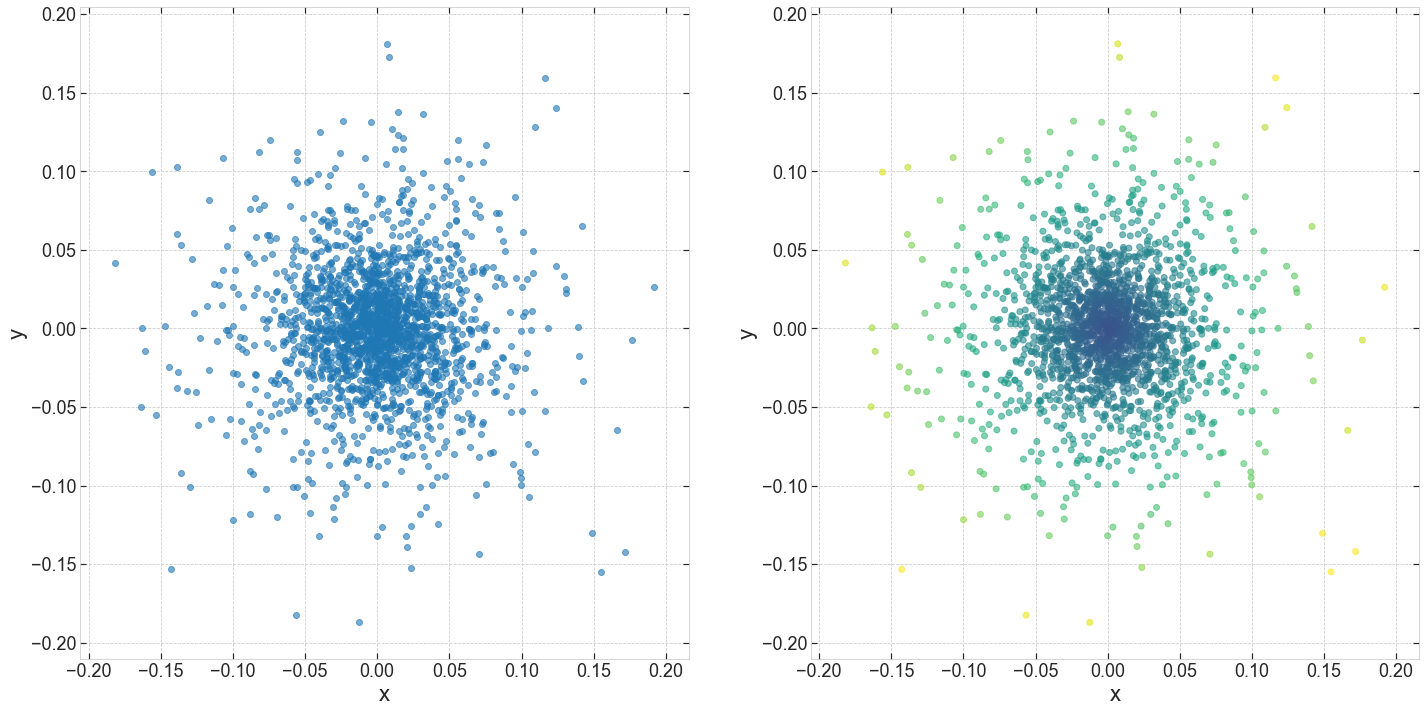

In [389]:
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*12,nrows*12))

axislabelsize = 22
axisticksize = 18
scatterradius = 6

ax[0].scatter(points[:,0], points[:,1],
              color='tab:blue', s=scatterradius**2, alpha=0.6)

ax[1].scatter(points[:,0], points[:,1],
              color=colors, s=scatterradius**2, alpha=0.6)

for i in range(ncols):
    ax[i].set_xlabel('x', fontsize=axislabelsize)
    ax[i].set_ylabel('y', fontsize=axislabelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=axisticksize)

if save:
    fig.savefig(figsave_dir +
                'boltzmann_points.png')
    
plt.show()

### Generating peaks on a discrete grid

In [436]:
# Generate gridpoint values
step_x = (xmax - xmin) / nx
step_y = (ymax - ymin) / ny
coords_x = np.arange(xmin, xmax, step_x)
coords_y = np.arange(ymin, ymax, step_y)
# Grid coordinates
# X contains x coordinates of gridpoints
# Y contains y coordinates of gridpoints
Xc, Yc = np.meshgrid(coords_x, coords_y)
# Values in gridpoints
Zc = np.zeros((nx,ny))

# Number of random peaks
n_peaks = 100
# Height of peaks
peak_height = -100
# Wheter to have values with different signs of not
signed = False

# Peaks chosen so far
n = 0
while n < n_peaks:
    x = np.random.choice(coords_x)
    y = np.random.choice(coords_y)
    v = np.random.random()
    if v < boltzmann(np.sqrt((x-(xmax-xmin)/2)**2 + (y-(ymax-ymin)/2)**2),
                     r_0=2, C=e/kT):
        x_coord = np.where(coords_x == x)[0][0]
        y_coord = np.where(coords_y == y)[0][0]
        Zc[x_coord][y_coord] = peak_height
        if signed:
            Zc[x_coord][y_coord] *= sign_choose()
        n += 1

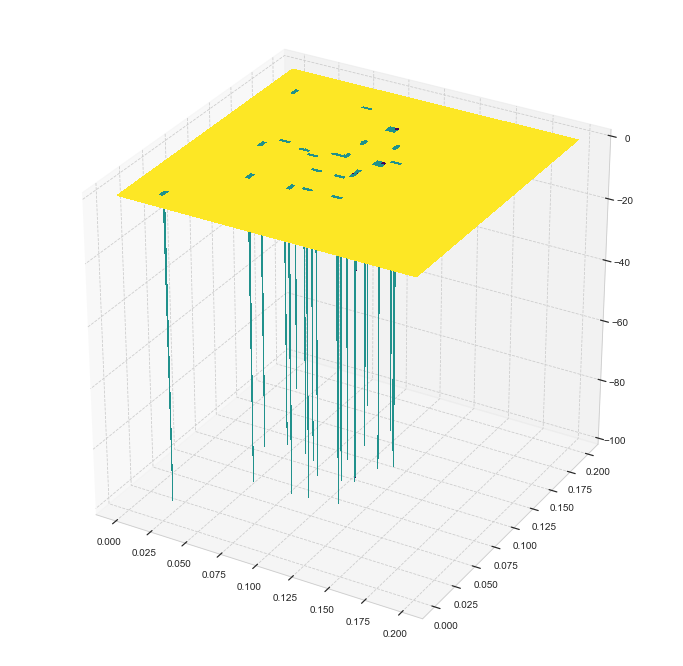

In [437]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

# Plot the surface.
ax.plot_surface(Xc, Yc, Zc, cmap='viridis', linewidth=0, antialiased=False)

plt.show()

In [438]:
p  = np.zeros((ny, nx))
b  = np.zeros((ny, nx))
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

start = datetime.now()
p_poibol_dist = poissonboltzmann2d(p, y, Zc, dx, dy, l1norm_target=1e-4)
clear_output()
print('Elapsed time :', datetime.now() - start)

Elapsed time : 0:01:31.734624


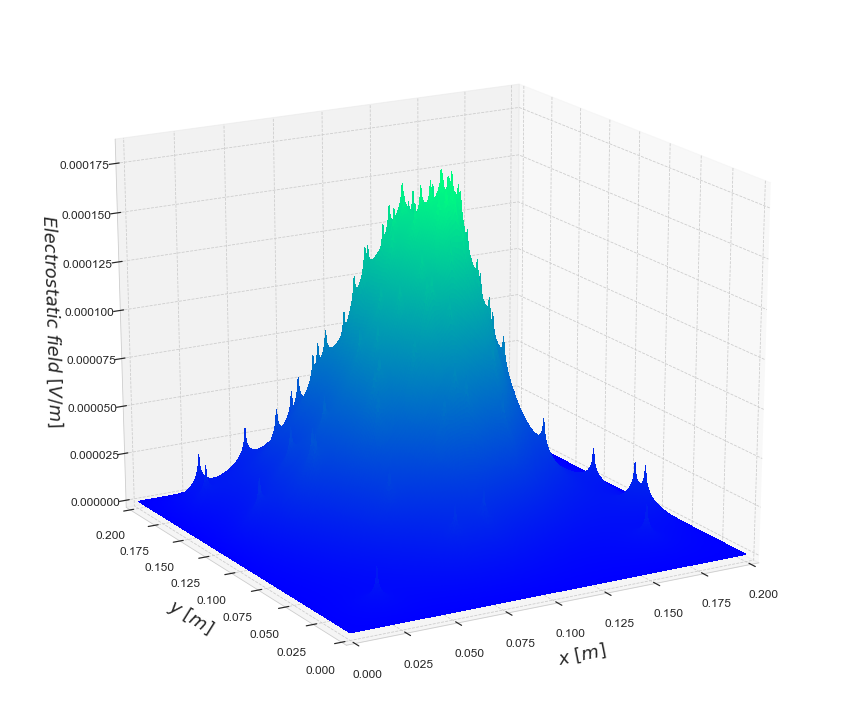

In [439]:
save = True
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsize_x,nrows*figsize_y),
                         subplot_kw={'projection': '3d'})
axes.view_init(20, 240)

axislabelsize = 18
axisticksize = 12
axislabelpad = 19
axistickpad = 12

X, Y = np.meshgrid(x, y)
axes.plot_surface(X, Y, p_poibol_dist,
                  rstride=1, cstride=1, cmap='winter', linewidth=0, antialiased=False)

axes.set_xlim(xmin, xmax)
axes.set_ylim(ymin, ymax)
axes.set_xlabel('$x\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_ylabel('$y\ [m]$',
                labelpad=axislabelpad, fontsize=axislabelsize)
axes.set_zlabel('$Electrostatic\ field\ [V/m]$',
                labelpad=axislabelpad+5, fontsize=axislabelsize)

axes.tick_params(axis='both', which='major',
                 pad=axistickpad, labelsize=axisticksize)

if save:
    if signed:
        filename = 'p_poibol_dist0'
    else:
        filename = 'p_poibol_dist1'
    
    fig.savefig(figsave_dir +
                '{0}.png'.format(filename))

plt.show()